## The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit.

Our First step is to create instance of spark context which is done by SparkSession and then converted into a spark dataframe . The schema is displayed.
Note:1. If the path is different then change "bank-additional-full.csv" to the path where the csv file is stored
2. Due to the issue of dot operator in spark the column names which had dot have been changed to underscore 

## Import Libraries
#### We open the spark file and also print schema

Note:I saved my .csv file into drive D. And create the enviornment for the spark.Open the jupyter notebook by using pyspark command into the Ananconda promt. 

In [15]:
# Load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from pyspark import SparkContext, SparkConf
from pandas.tools.plotting import scatter_matrix
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import udf


# Load dataset (bank-additional-full.csv)
spark = SparkSession.builder.appName('ml-bank').getOrCreate() #Using a builder design pattern, it instantiates a SparkSession object 
df = spark.read.csv('bank-additional-full.csv', header = True, inferSchema = True, sep=';') # read the .csv file from the drive D.
df.printSchema() #apply schema to the dataframe


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



We use conventional python libraries (pandas)to understand the data, visualization and find missing values . 
We convert the csv file into a dataframe and use describe them

## Data Understanding 

In [16]:
#To show  First five data entries in the dataset
pd.DataFrame(df.take(6), columns=df.columns).transpose()

,0,1,2,3,4,5
age,56,57,37,40,56,45
job,housemaid,services,services,admin.,services,services
marital,married,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school,basic.9y
default,no,unknown,no,no,no,unknown
housing,no,no,yes,no,no,no
loan,no,no,no,no,yes,no
contact,telephone,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon,mon


In [17]:
print( df.toPandas().describe()) #basic descriptive statistics

               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp_var_rate  cons_price_idx  cons_conf_idx     euribor3m   nr_employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198    

In [18]:
print (df.toPandas().info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int32
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int32
campaign          41188 non-null int32
pdays             41188 non-null int32
previous          41188 non-null int32
poutcome          41188 non-null object
emp_var_rate      41188 non-null float64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int32(5), object(11)
memory usa

## Missing Values

In [19]:
# To find missing values i use pandas
# These missing values are for only integer datatypes
def count_nulls(df):
    null_counts = []          #make an empty list to hold our results
    for col in df.dtypes:     #iterate through the column data types we saw above, e.g. ('C0', 'bigint')
        cname = col[0]        #splits out the column name, e.g. 'C0'    
        ctype = col[1]        #splits out the column type, e.g. 'bigint'
        
        #print(ctype)
        if (ctype == str('int')): #skip processing string columns for efficiency (can't have nulls)
           
            nulls = df.where( df[cname].isNull() ).count()
            result = tuple([cname, nulls])  #new tuple, (column name, null count)
            null_counts.append(result)      #put the new tuple in our result list
    return null_counts

null_counts = count_nulls(df)
#null_counts(train)
print (null_counts)

[('age', 0), ('duration', 0), ('campaign', 0), ('pdays', 0), ('previous', 0)]


In [20]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import isnan, when, count, col,sum
ColumnNames = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

#checking for is null
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()
#checking for isnan
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+

## Visualization

Note: For visualization purpose we use pandas dataframe (We convert train dataset into pandas dataframe using toPandas()

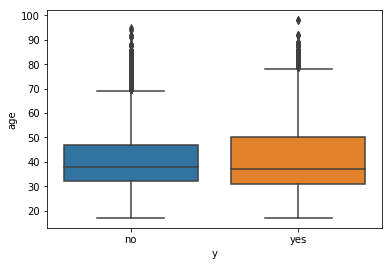

In [21]:
# age
sns.boxplot(x='y', y='age', data=df.toPandas())

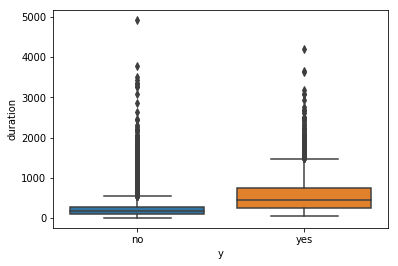

In [22]:
#duration
sns.boxplot(x='y', y='duration', data=df.toPandas())

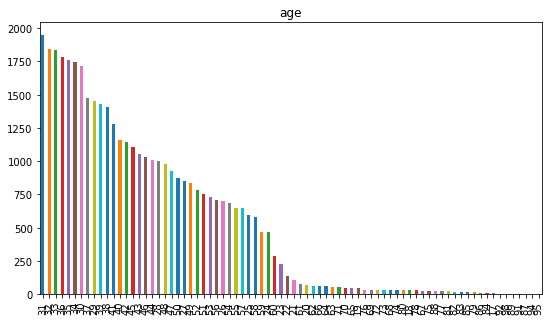

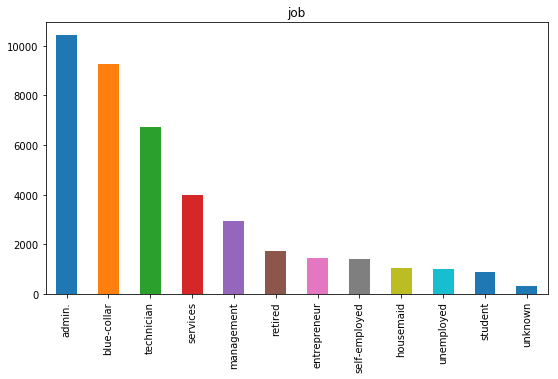

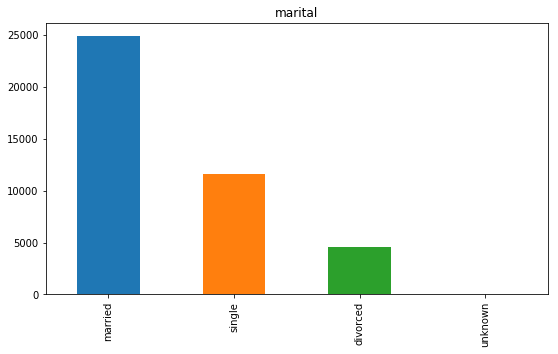

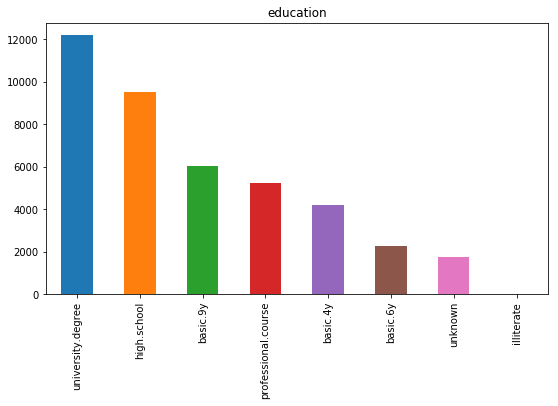

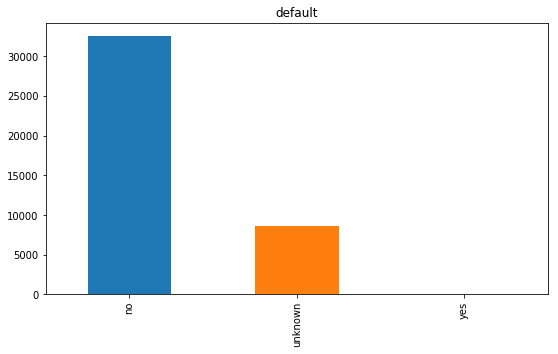

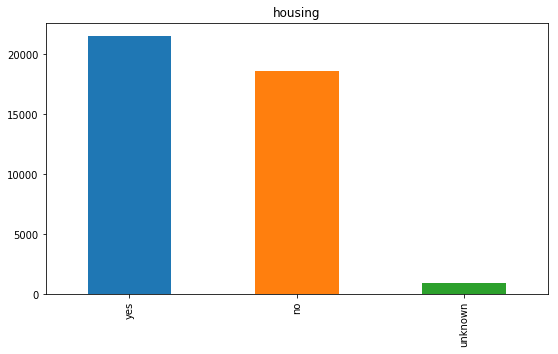

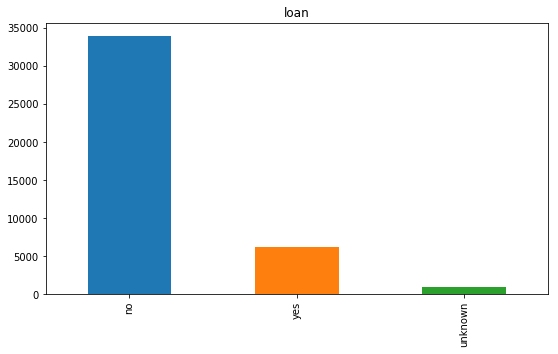

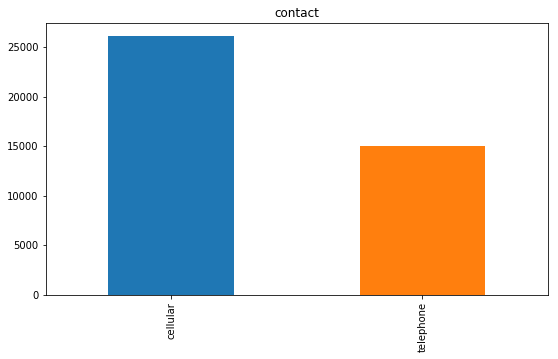

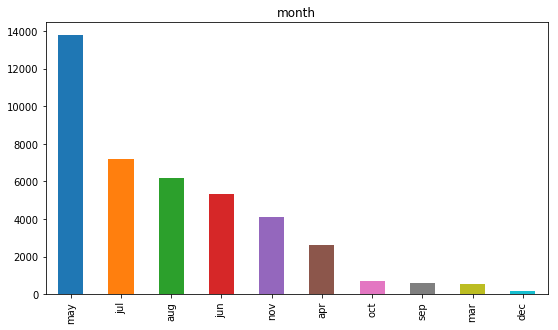

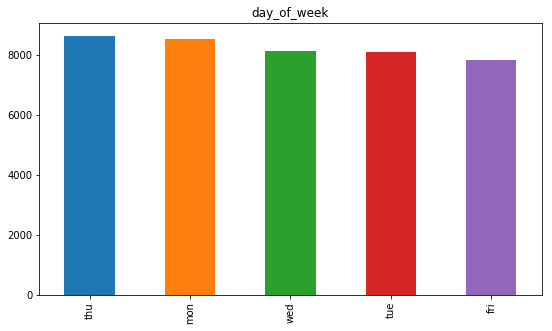

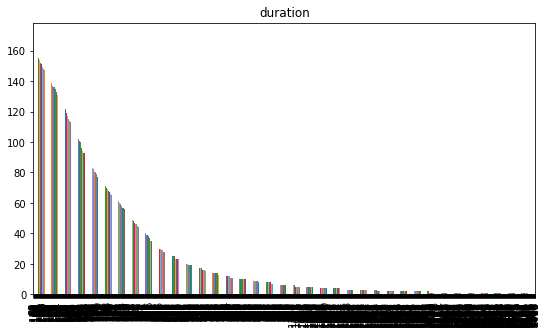

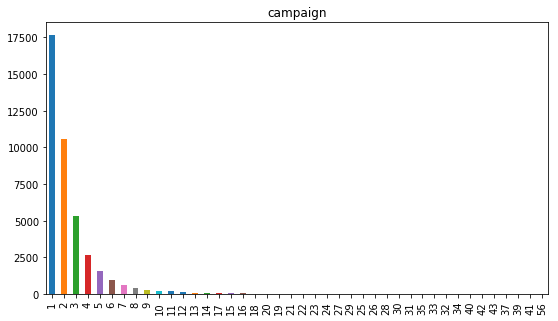

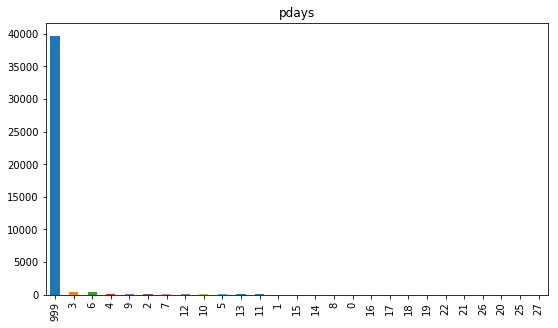

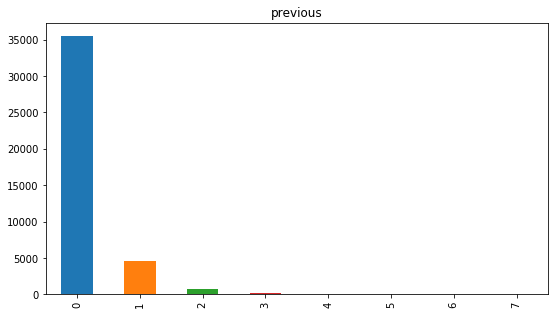

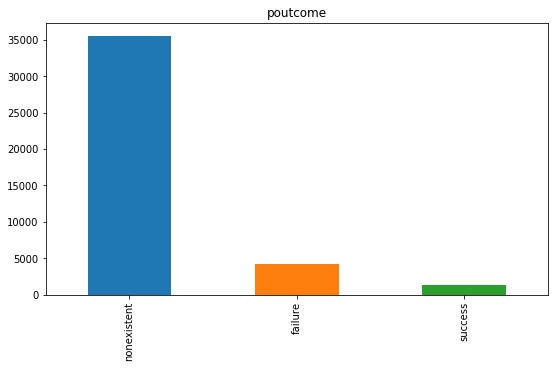

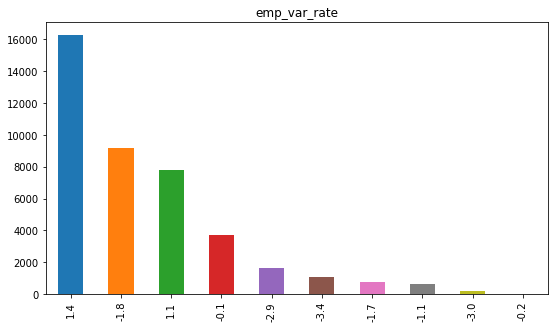

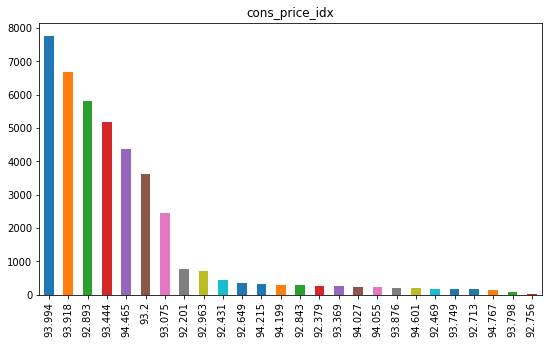

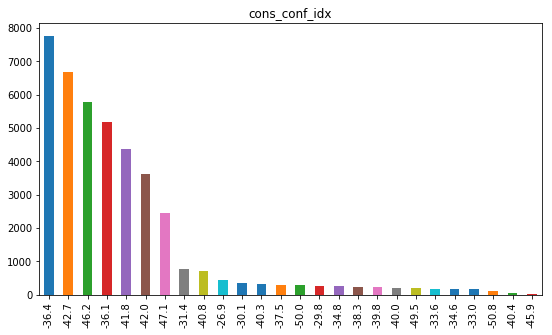

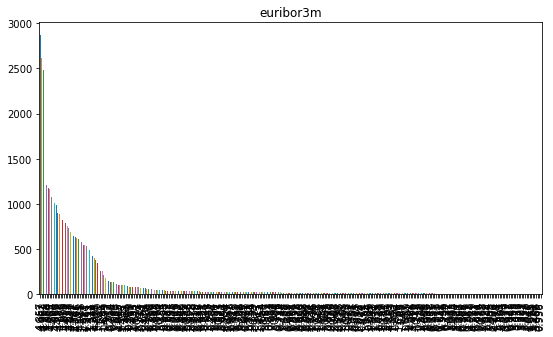

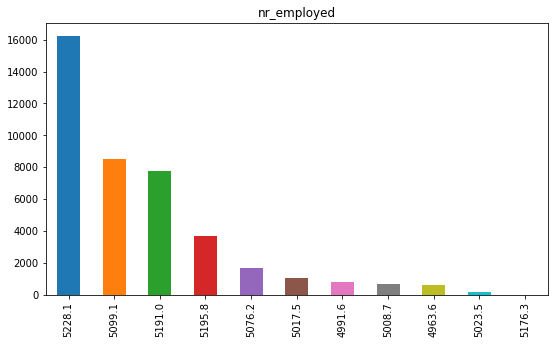

In [23]:
# visualize categorical features
categorical = ColumnNames
for i in categorical:
    df.toPandas()[i].value_counts().plot(kind='bar',figsize = (9, 5),title=i)
    plt.show()

##  Divide the data into integer and categorical column

In [24]:
#df = df.select('age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y')

cols = df.columns
TypesinData = df.dtypes
print(TypesinData)
IntegerCols = []
CatCols = []
for each in TypesinData:
    if ((each[1] == 'int' or each[1] == 'double') and each[0] != 'label'):
        IntegerCols.append(each[0])
    elif (each[0] != 'y'):
        CatCols.append(each[0])
print (IntegerCols)
print (CatCols)

[('age', 'int'), ('job', 'string'), ('marital', 'string'), ('education', 'string'), ('default', 'string'), ('housing', 'string'), ('loan', 'string'), ('contact', 'string'), ('month', 'string'), ('day_of_week', 'string'), ('duration', 'int'), ('campaign', 'int'), ('pdays', 'int'), ('previous', 'int'), ('poutcome', 'string'), ('emp_var_rate', 'double'), ('cons_price_idx', 'double'), ('cons_conf_idx', 'double'), ('euribor3m', 'double'), ('nr_employed', 'double'), ('y', 'string')]
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [25]:
##reference: https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = CatCols
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = IntegerCols
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [26]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



## Splitting into Train and Test

In [27]:
train, test = df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32922
Test Dataset Count: 8266


## Generalized Linear Regression

In [28]:
#linear regression
from pyspark.ml.regression import GeneralizedLinearRegression

Gen_linReg = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=10, regParam=0.3)
FittingModel = Gen_linReg.fit(train)

print("Intercept: " + str(FittingModel.intercept))

# Summarize the model over the training set and print out some metrics
summary = FittingModel.summary

print("Dispersion: " + str(summary.dispersion))
print("Null Deviance: " + str(summary.nullDeviance))
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
print("Deviance: " + str(summary.deviance))
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
print("AIC: " + str(summary.aic))
print("Deviance Residuals: ")
summary.residuals().show()

Intercept: 1.90294176231277
Dispersion: 0.07045998576507208
Null Deviance: 3299.6610169490514
Residual Degree Of Freedom Null: 32921
Deviance: 2315.878812126389
Residual Degree Of Freedom: 32868
AIC: 6152.01568215849
Deviance Residuals: 
+--------------------+
|   devianceResiduals|
+--------------------+
|-0.02650895599312...|
|-0.06040394403001...|
|-0.02873076421146381|
|-0.03198888251957421|
|-0.03483285987446694|
|-0.03452629100064808|
|-0.04891214577552483|
|-0.05269841387843477|
| -0.0369183205610184|
|-0.17069312654028712|
|-0.25207163712628944|
|-0.05899172234303918|
|-0.03516550014322606|
|-0.15025228140489277|
|-0.37047000243179373|
|-0.07141255671083879|
|-0.03444333534908273|
|-0.02579469411924...|
|-0.03666402570541272|
|-0.02323903208387157|
+--------------------+
only showing top 20 rows



### Output of linear regression
We can get a idea of the how regression works with the data 

## Logistic Regression

In [29]:
from pyspark.ml.classification import LogisticRegression
logistic = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = logistic.fit(train)

## Summary of false posititve and true positive

In [30]:

trainingSummary = lrModel.summary

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.

print("areaUnderROC: " + str(trainingSummary.areaUnderROC))
trainingSummary.roc.show()


areaUnderROC: 0.868850072317922
+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|0.002739538387781659|0.06693548387096775|
|0.006266694062050544|0.12768817204301075|
|0.010512978563112115| 0.1827956989247312|
|0.015820834189439078| 0.2295698924731183|
|0.022121772481336895| 0.2685483870967742|
| 0.02845695500308198|  0.307258064516129|
| 0.03537428943223067|0.34139784946236557|
| 0.04287377576878296| 0.3709677419354839|
| 0.05068146017396069| 0.3981182795698925|
| 0.05883158687761112|0.42258064516129035|
| 0.06636531744401068|0.45188172043010755|
| 0.07437846722827203| 0.4774193548387097|
| 0.08252859393192247| 0.5018817204301075|
| 0.09098691870419834| 0.5239247311827957|
| 0.09893158002876515|               0.55|
|  0.1080063009382919| 0.5672043010752689|
| 0.11649886994041504| 0.5889784946236559|
| 0.12471748510376002| 0.6129032258064516|
| 0.13324429833573043|

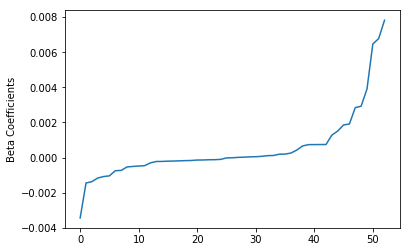

In [31]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

## The Receiver Operating Characteristic (ROC) Curve

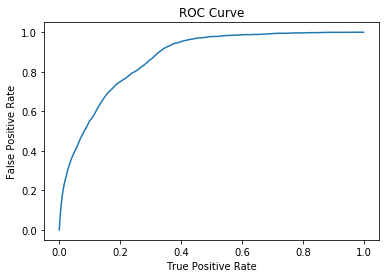

Training set areaUnderROC: 0.868850072317922


In [32]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## Precision and recall

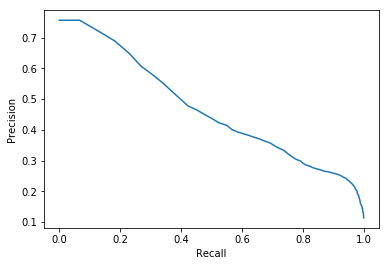

In [33]:
# Plot graph of the precision and recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Prediction on test data

In [34]:
# Prediction for Testdata 
# We are showing 10 entires of age and job.
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 53|admin.|  0.0|[2.06988048936183...|       0.0|[0.88794107047957...|
| 42|admin.|  0.0|[2.06622033177936...|       0.0|[0.88757636103021...|
| 57|admin.|  0.0|[2.06559464519194...|       0.0|[0.88751391202473...|
| 31|admin.|  0.0|[2.06578619807041...|       0.0|[0.88753303389765...|
| 31|admin.|  0.0|[2.06175417699422...|       0.0|[0.88712993571110...|
| 36|admin.|  0.0|[2.06555671228795...|       0.0|[0.88751012501467...|
| 37|admin.|  0.0|[2.06878800261816...|       0.0|[0.88783232008329...|
| 46|admin.|  0.0|[2.06729907046853...|       0.0|[0.88768395750455...|
| 50|admin.|  0.0|[2.06494090068346...|       0.0|[0.88744863023430...|
| 53|admin.|  0.0|[2.05991293899700...|       0.0|[0.88694544033436...|
+---+------+-----+--------------------+----------+--------------

## Evaluation of Logistic Regression model

In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8697728133619094


## Decision tree Classifier
Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multi-class classification, do not require feature scaling, and are able to capture non-linearities and feature interactions.

In [42]:
from pyspark.ml.classification import DecisionTreeClassifier
DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
DT_Model = DT.fit(train)
predictions = DT_Model.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)


+---+------+-----+---------------+----------+--------------------+
|age|   job|label|  rawPrediction|prediction|         probability|
+---+------+-----+---------------+----------+--------------------+
| 53|admin.|  0.0|[23835.0,411.0]|       0.0|[0.98304875030932...|
| 42|admin.|  0.0|[23835.0,411.0]|       0.0|[0.98304875030932...|
| 57|admin.|  0.0|[23835.0,411.0]|       0.0|[0.98304875030932...|
| 31|admin.|  0.0|[23835.0,411.0]|       0.0|[0.98304875030932...|
| 31|admin.|  0.0|[23835.0,411.0]|       0.0|[0.98304875030932...|
| 36|admin.|  0.0|[23835.0,411.0]|       0.0|[0.98304875030932...|
| 37|admin.|  0.0|[23835.0,411.0]|       0.0|[0.98304875030932...|
| 46|admin.|  0.0|[23835.0,411.0]|       0.0|[0.98304875030932...|
| 50|admin.|  0.0|[23835.0,411.0]|       0.0|[0.98304875030932...|
| 53|admin.|  0.0| [1162.0,640.0]|       0.0|[0.64483906770255...|
+---+------+-----+---------------+----------+--------------------+
only showing top 10 rows



In [37]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7232127954876361


One simple decision tree performed poorly because it is too weak given the range of different features. The prediction accuracy of decision trees can be improved by Ensemble methods, such as Random Forest.

## Randomforest Classifier

In [40]:
from pyspark.ml.classification import RandomForestClassifier
Rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
Rf_Model = Rf.fit(train)
predictions = Rf_Model.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 53|admin.|  0.0|[19.3605180266537...|       0.0|[0.96802590133268...|
| 42|admin.|  0.0|[19.2985844919105...|       0.0|[0.96492922459552...|
| 57|admin.|  0.0|[19.2985844919105...|       0.0|[0.96492922459552...|
| 31|admin.|  0.0|[19.2168416753813...|       0.0|[0.96084208376906...|
| 31|admin.|  0.0|[18.7478084364397...|       0.0|[0.93739042182198...|
| 36|admin.|  0.0|[19.2269175053312...|       0.0|[0.96134587526656...|
| 37|admin.|  0.0|[19.3083474954007...|       0.0|[0.96541737477003...|
| 46|admin.|  0.0|[19.2269175053312...|       0.0|[0.96134587526656...|
| 50|admin.|  0.0|[19.2269175053312...|       0.0|[0.96134587526656...|
| 53|admin.|  0.0|[14.7944225693893...|       0.0|[0.73972112846946...|
+---+------+-----+--------------------+----------+--------------

## Evaluate our Random Forest Classifier.

In [39]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9191901241728759


 ### I can conclude that the best model to be used is the random forest.